## 1, ライブラリをインポート

In [83]:
import os, io, re
import cv2
import glob
import pickle
import shap
import copy
import optuna
import graphviz
import pydotplus
import lightgbm as lgb
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'family' : 'meiryo'}
plt.rc('font', **font)

In [84]:
from PIL import Image
from functools import partial
from pycm import ConfusionMatrix

from sklearn.externals.six import StringIO
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

import keras.backend as K
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import random_rotation, random_shift, random_zoom, img_to_array, array_to_img

In [85]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12827736086200502679,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4937233203
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6677770713062109803
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

## 2, 学習データを前処理

In [86]:
for i,file in enumerate(os.listdir("./csv/")):
    if i == 0:
        df = pd.read_csv("./csv/" + file, encoding="SJIS")
    else:
        df = pd.concat([df,pd.read_csv("./csv/" +file, encoding="SJIS")])
        
df.columns = ["image","front","close","background","focus","cute","position","brightness","plural","care"]
df = df.reset_index(drop=True)
df["image"] = [("00000" + i) for i in df["image"]]
df

image  front  close  background  focus  cute  position  \
0    00000025_018.jpg      5      5           5      4     2         4   
1    00000025_022.jpg      5      4           3      4     3         4   
2    00000025_029.jpg      3      3           3      5     4         3   
3    00000026_001.jpg      5      3           2      4     4         3   
4    00000026_008.jpg      5      3           4      5     3         3   
..                ...    ...    ...         ...    ...   ...       ...   
695  00000011_025.jpg      4      3           4      5     4         3   
696  00000011_027.jpg      5      4           2      4     4         3   
697  00000012_010.jpg      5      3           5      5     5         3   
698  00000012_022.jpg      3      3           4      3     3         4   
699  00000012_025.jpg      3      3           2      3     3         3   

     brightness  plural  care  
0             2       0     0  
1             2       0     0  
2             2       0     1  
3             3       0     1  
4             3       0     0  
..          ...     ...   ...  
695           3       2     0  
696           3       0     0  
697           3       0     1  
698           3       0     0  
699           3       0     0  

[700 rows x 10 columns]

Data must have variance to compute a kernel density estimate.


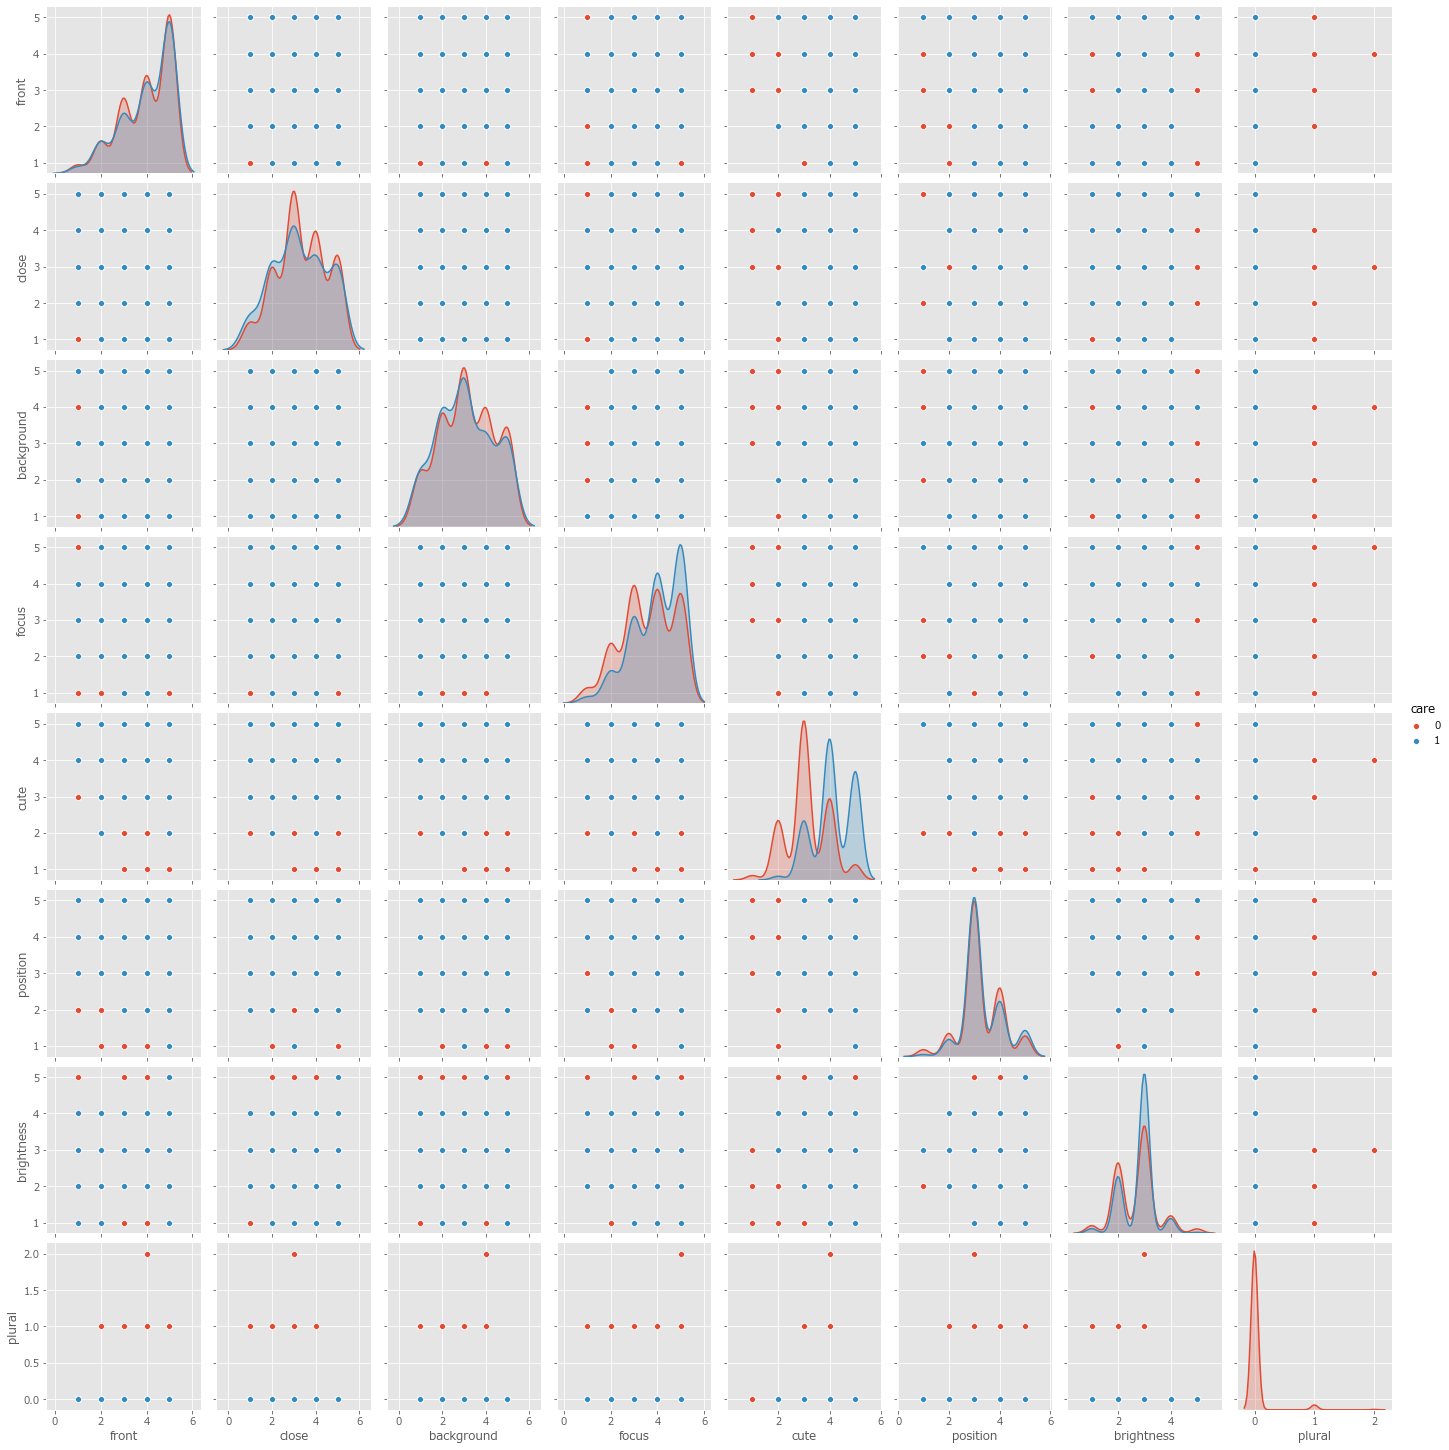

In [87]:
#離散なのに散布図です・・・欲しいのは対角線に表示されている確率密度です。
g = sns.pairplot(df.drop("image",axis=1),hue="care")
g.fig.set_figheight(20)
g.fig.set_figwidth(20)

In [88]:
#水増しフラグ
padding_flag = True

In [89]:
image_size=120
X=[]

for image_path in df["image"]:
    #画像ファイル取得
    img_file = glob.glob("./image/" + image_path)
    if not img_file:
        print(image_path)
        continue
    image = Image.open(img_file[0])
    image = image.convert("RGB")
    image = image.resize((image_size, image_size))
    X.append(np.array(image))
    
del image

## 3, 小モデル作成

In [90]:
def create_model1():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = 3, activation="relu", input_shape=(image_size,image_size,3)))
    model.add(Conv2D(16, kernel_size = 3, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, kernel_size = 3, activation="relu"))
    model.add(Conv2D(32, kernel_size = 3, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size = 3, activation="relu"))
    model.add(Conv2D(64, kernel_size = 3, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [91]:
def create_model2():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = 4, activation="relu", input_shape=(image_size,image_size,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [92]:
def column_predict(X_train,X_valid,y_train,y_valid,column):
    
    sess = tf.InteractiveSession()
    
    model = create_model1()
    callbacks = [ReduceLROnPlateau(monitor='loss', patience=4, verbose=1, factor=0.7),
             EarlyStopping(monitor='loss', patience=10)]
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    model.summary()
    
    hist = model.fit(X_train, y_train, epochs=60, batch_size=30,verbose=0,callbacks=callbacks)
    pickle.dump(model,open("model/model_" + str(column) + ".sav","wb"))
    
    pred = model.predict(X_valid)
    MSE_pred = mean_squared_error(pred, y_valid)

    mean_pred = np.full(len(y_valid), y_train.mean())
    MSE_mean = mean_squared_error(mean_pred, y_valid)
    
    fig = plt.figure(figsize=(12, 16))
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(column, fontsize=20)
    
    ax1 = fig.add_subplot(211,
                          title="Loss",
                          ylabel="Loss",
                          xlabel="Epoch")
    ax1.plot(hist.history["loss"])
    ax1.legend(["Train", "Test"], loc="upper left")

    ax2 = fig.add_subplot(212,
                          title="pred(mse):" + str(MSE_pred)[:5] + "\n" +"baseline(mse):" + str(MSE_mean)[:5],
                          ylabel="Score",
                          xlabel="ID")
    ax2.plot(y_valid, label="Actual")
    ax2.plot(pred, label="Pred")
    ax2.plot(mean_pred, label="Mean")
    ax2.legend(loc="upper right")
    
    plt.show()

    
    with tf.Session() as sess:
         sess.run(tf.global_variables_initializer())
    
    explainer = shap.DeepExplainer(model, (X_train[0:20]*255))
    for i in range(3):
        index_names = np.array("True:" + str(y_valid[i]) + "\n" + "Pred:" + str(pred[i][0])[:4]).reshape(1,1)
        shap_values = explainer.shap_values(X_valid[[i]]*255)
        shap.image_plot(shap_values, X_valid[[i]], index_names)
        plt.gcf().set_size_inches(20, 20)
    
    return(pred)
    

In [93]:
X = np.array(X)
Y = np.array(df[["front","close","background","focus","cute","position","brightness","plural","care"]])

X_train, X_valid, y_train, y_valid = train_test_split(X,Y,random_state = 1,test_size = 0.15)

y_train,care_train = np.hsplit(y_train, [len(y_train[0])-1])
y_valid,care_valid = np.hsplit(y_valid, [len(y_valid[0])-1])

In [94]:
#レーダーチャート関数
def plot_polar(labels, values, values2 = np.array([])):
    angles = np.linspace(0, 2 * np.pi, len(labels) + 1, endpoint=True)
    values = np.concatenate((values, [values[0]]))  # 閉じた多角形にする
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, 'o-', label="True")  # 外枠
    if len(values2) != 0:
        values2 = np.concatenate((values2, [values2[0]]))  # 閉じた多角形にする
        ax.plot(angles, values2, 'o-', label="Pred")
        ax.legend(loc=(0.01, 0.01))
    ax.fill(angles, values, alpha=0.25)  # 塗りつぶし
    ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels)  # 軸ラベル
    ax.set_rlim(0 ,5)
    plt.show()

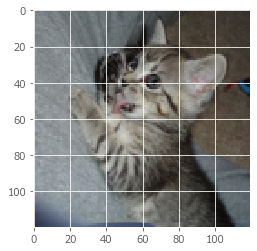

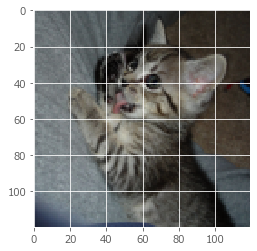

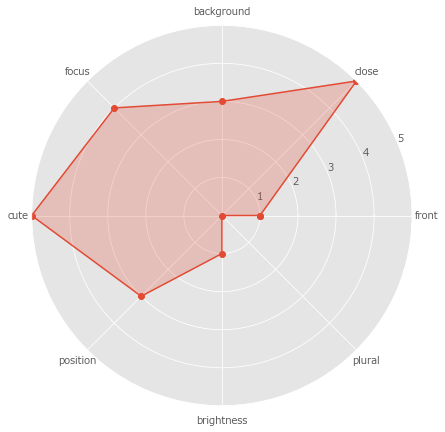

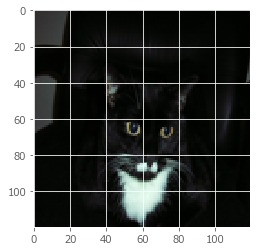

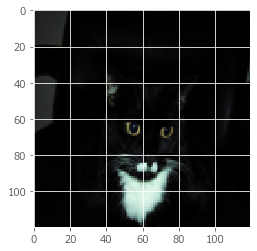

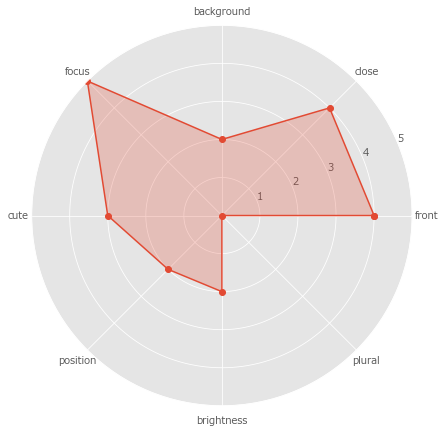

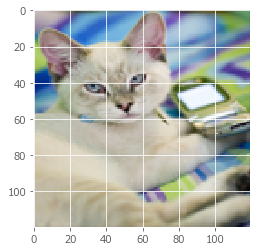

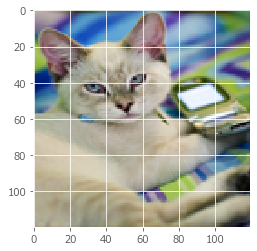

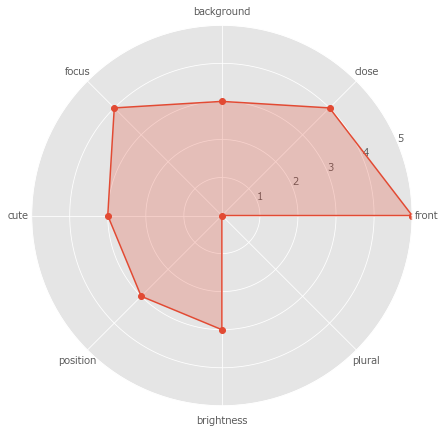

In [95]:
if padding_flag:
    
    #水増し(回転)を入れる予定
    #水増し(ガンマ変換)
    X_train = list(X_train)
    
    gamma = 0.8
    look_up_table = np.ones((256, 1), dtype = 'uint8' ) * 0
    for i in range(256):
        look_up_table[i][0] = 255 * pow(float(i) / 255, 1.0 / gamma)
    X_train_gamma = []
    X_train_rotate_r = []
    X_train_rotate_l = []
    
    for i in range(len(X_train)):
        img = np.array(X_train[i]).transpose(1, 2, 0)
        img_gamma = cv2.LUT(img, look_up_table)
        X_train_gamma.append(list(img_gamma.transpose(2,0,1)))
        
        rotate_r = copy.deepcopy(X_train[i])
        rotate_l = copy.deepcopy(X_train[i])
        
        X_train_rotate_r.append(img_to_array(array_to_img(rotate_r).rotate(3)).astype('int32'))
        X_train_rotate_l.append(img_to_array(array_to_img(rotate_l).rotate(360 - 3)).astype('int32'))

    X_train_gamma = np.array(X_train_gamma)
    X_train_rotate_r = np.array(X_train_rotate_r)
    X_train_rotate_l = np.array(X_train_rotate_l)
    
    X_train = np.vstack((X_train,X_train_gamma))
    X_train = np.vstack((X_train,X_train_rotate_r))
    X_train = np.vstack((X_train,X_train_rotate_l))
    
    #ガンマ変換によるラベル修正(明暗値を1下げる)
    y_train_gamma = copy.deepcopy(y_train)
    y_train_rotate_r = copy.deepcopy(y_train)
    y_train_rotate_l = copy.deepcopy(y_train)
    
    #for i in range(len(y_train_gamma)):
    #    brightness = y_train_gamma[i][6]
    #    if brightness != 1:
    #        brightness -= 1
    #    y_train_gamma[i][6] = brightness
    y_train = np.append(y_train,y_train_gamma,axis=0)
    y_train = np.append(y_train,y_train_rotate_r,axis=0)
    y_train = np.append(y_train,y_train_rotate_l,axis=0)
    
    #スコア、解像度、ガンマ変換を確認
    for i in range(3):
        plt.imshow(X_train[i])
        plt.show()
        
        plt.imshow(X_train[i + int(len(X_train)/4)])
        plt.show()
        
        plot_polar(["front","close","background","focus","cute","position","brightness","plural"], y_train[i])

X_train = X_train.astype("float32") / 255
X_valid = X_valid.astype("float32") / 255

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 118, 118, 16)      448       
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 116, 116, 16)      2320      
_________________________________________________________________
batch_normalization_65 (Batc (None, 116, 116, 16)      64        
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 56, 56, 32)        4640      
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 54, 54, 32)        9248      
___________________________

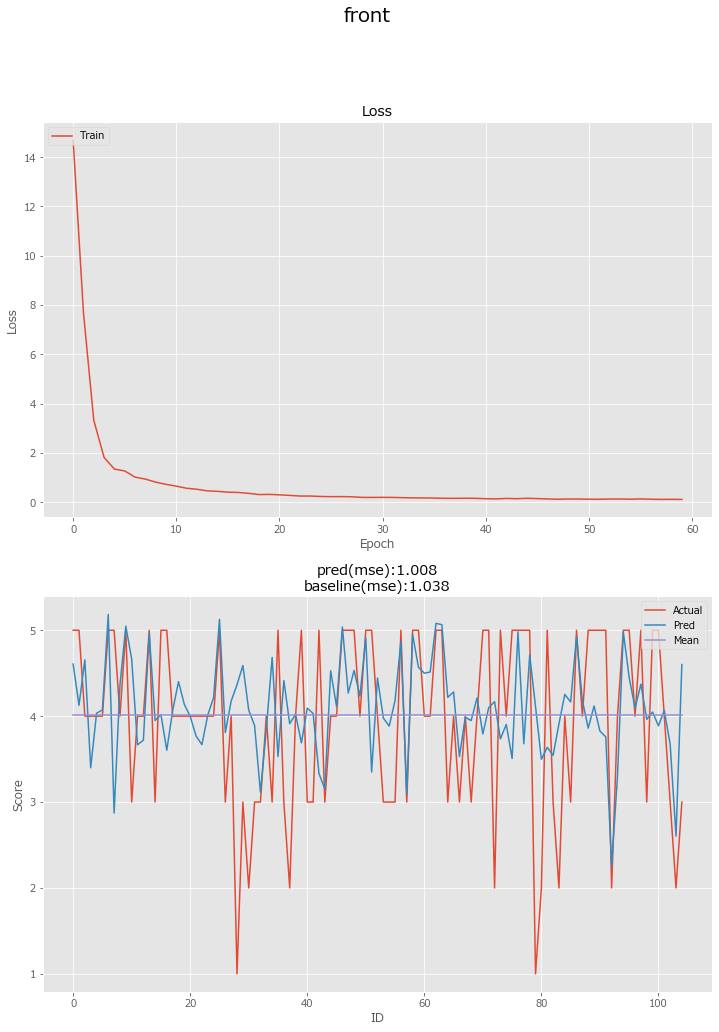

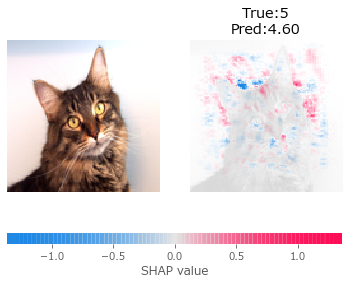

<Figure size 1440x1440 with 0 Axes>

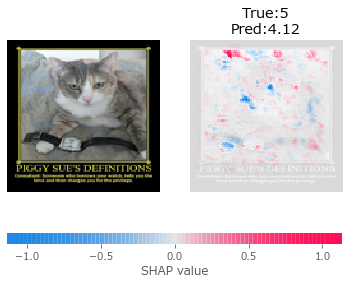

<Figure size 1440x1440 with 0 Axes>

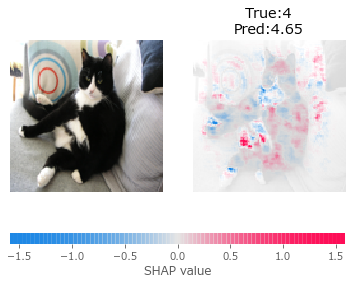

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 118, 118, 16)      448       
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 116, 116, 16)      2320      
_________________________________________________________________
batch_normalization_69 (Batc (None, 116, 116, 16)      64        
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 56, 56, 32)        4640      
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 54, 54, 32)        9248      
_________________________________________________________________
batch_normalization_70 (Batc (None, 54, 54, 32)        128       
__________

<Figure size 1440x1440 with 0 Axes>

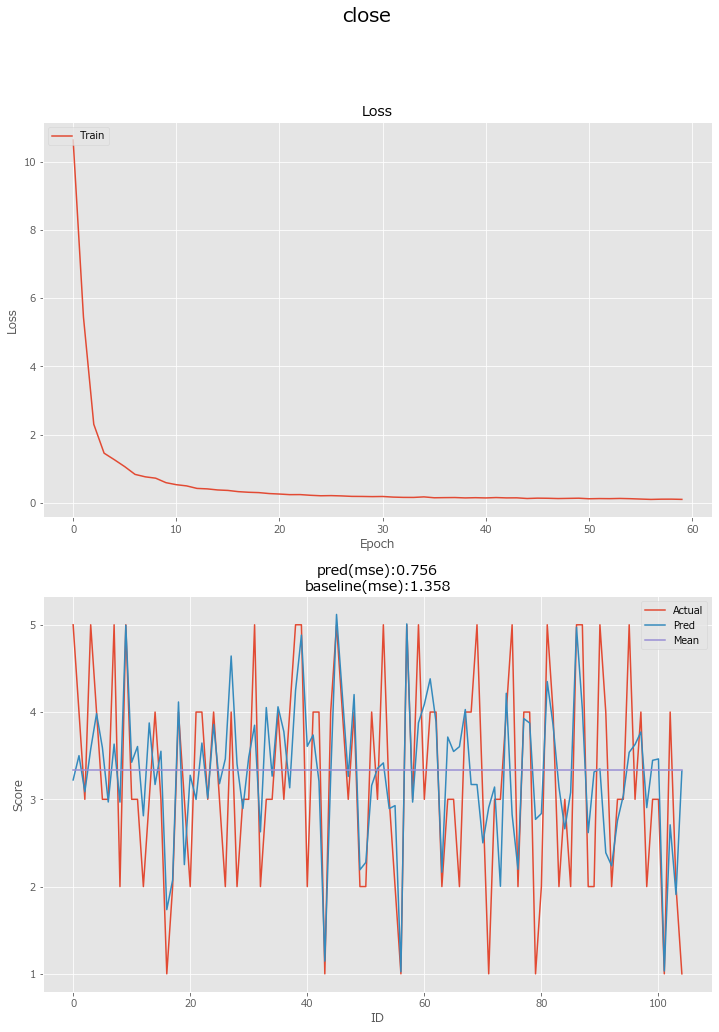

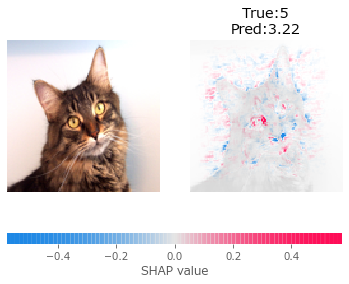

<Figure size 1440x1440 with 0 Axes>

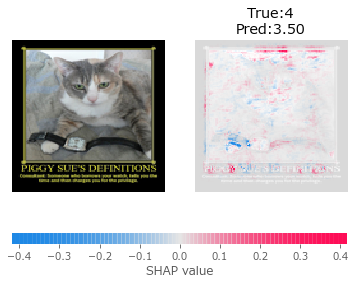

<Figure size 1440x1440 with 0 Axes>

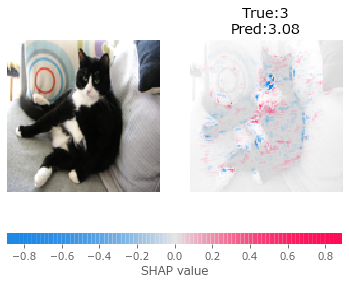

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 118, 118, 16)      448       
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 116, 116, 16)      2320      
_________________________________________________________________
batch_normalization_73 (Batc (None, 116, 116, 16)      64        
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 56, 56, 32)        4640      
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 54, 54, 32)        9248      
_________________________________________________________________
batch_normalization_74 (Batc (None, 54, 54, 32)        128       
__________

<Figure size 1440x1440 with 0 Axes>

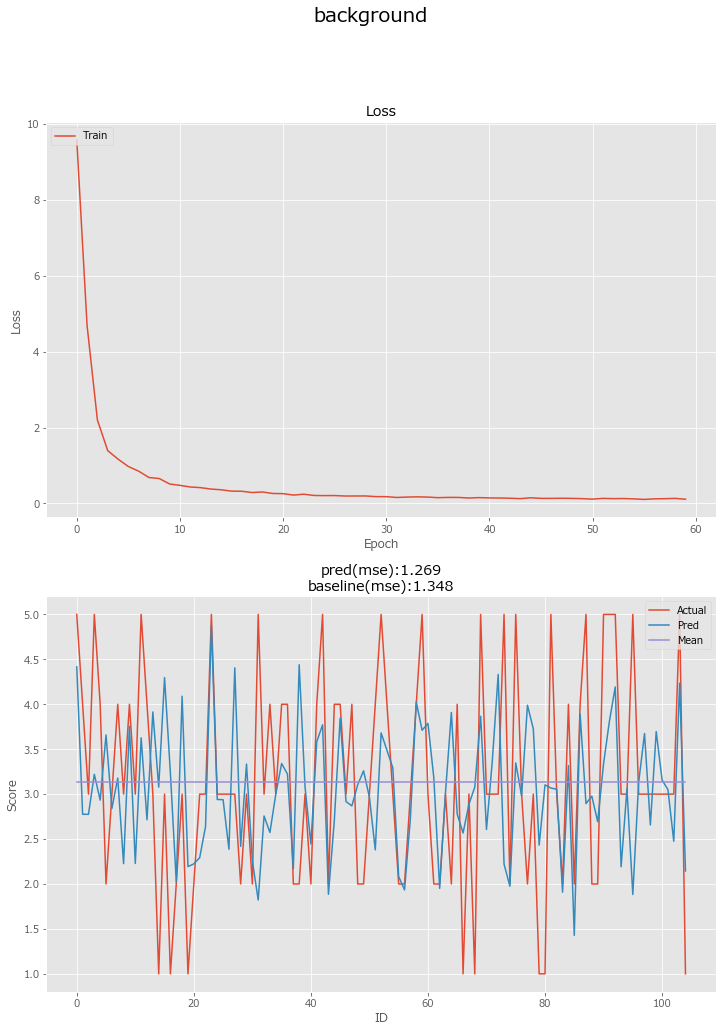

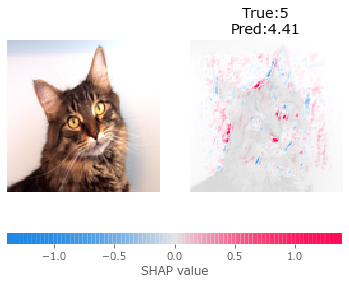

<Figure size 1440x1440 with 0 Axes>

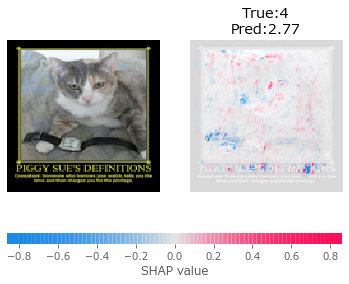

<Figure size 1440x1440 with 0 Axes>

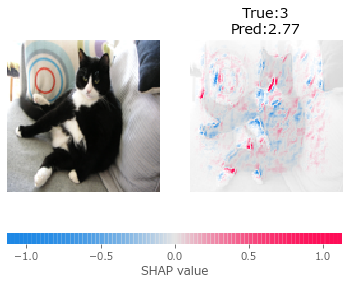

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 118, 118, 16)      448       
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 116, 116, 16)      2320      
_________________________________________________________________
batch_normalization_77 (Batc (None, 116, 116, 16)      64        
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 56, 56, 32)        4640      
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 54, 54, 32)        9248      
_________________________________________________________________
batch_normalization_78 (Batc (None, 54, 54, 32)        128       
__________

<Figure size 1440x1440 with 0 Axes>

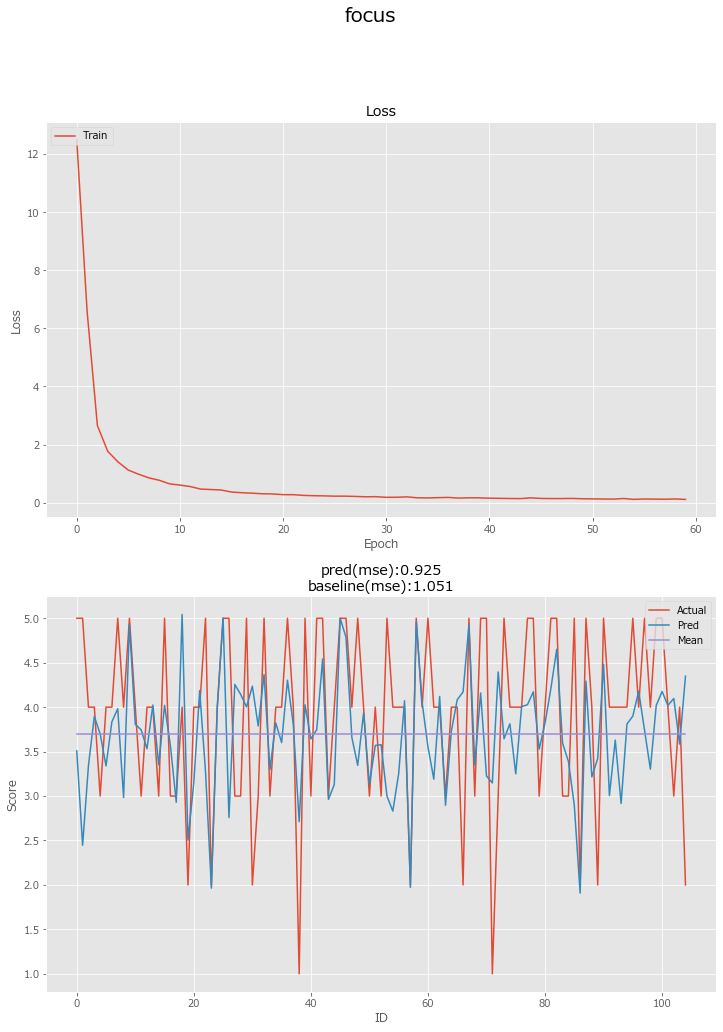

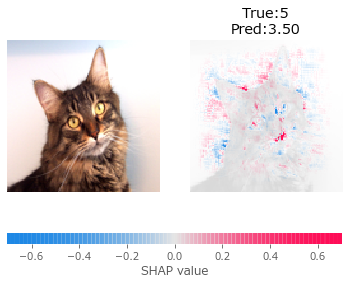

<Figure size 1440x1440 with 0 Axes>

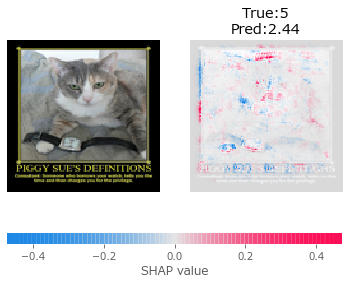

<Figure size 1440x1440 with 0 Axes>

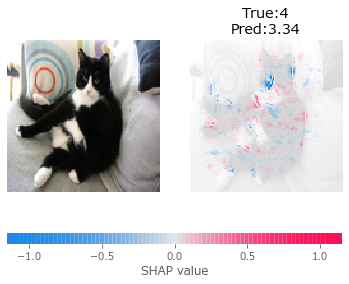

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 118, 118, 16)      448       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 116, 116, 16)      2320      
_________________________________________________________________
batch_normalization_81 (Batc (None, 116, 116, 16)      64        
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 32)        4640      
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 54, 54, 32)        9248      
_________________________________________________________________
batch_normalization_82 (Batc (None, 54, 54, 32)        128       
__________

<Figure size 1440x1440 with 0 Axes>

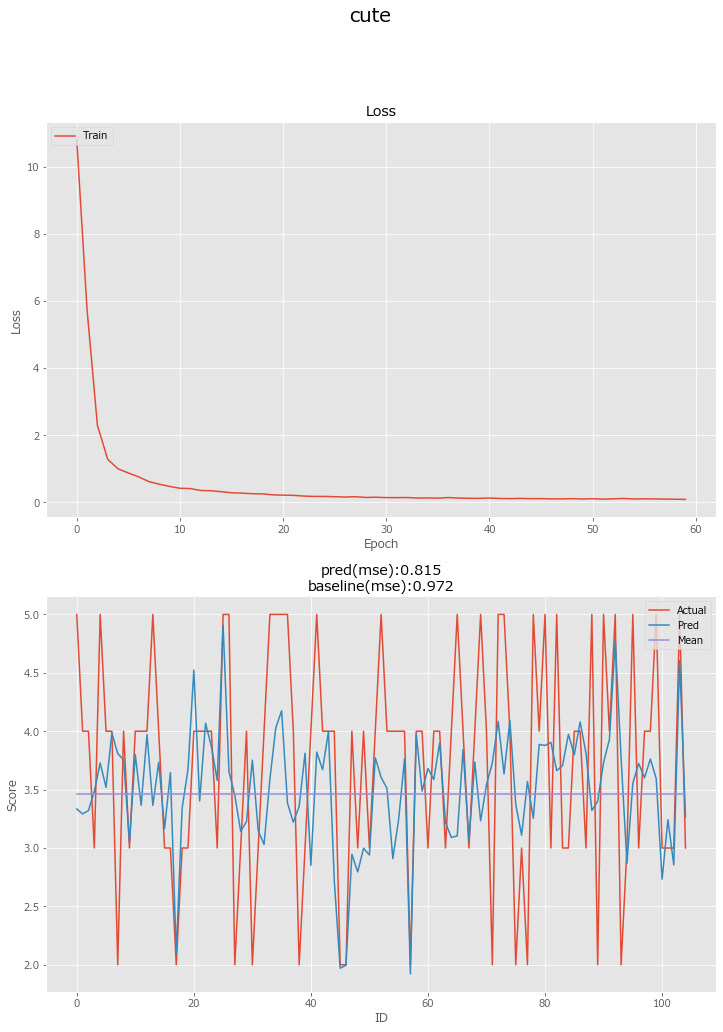

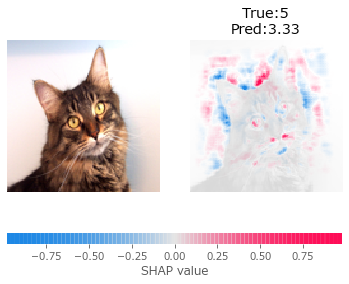

<Figure size 1440x1440 with 0 Axes>

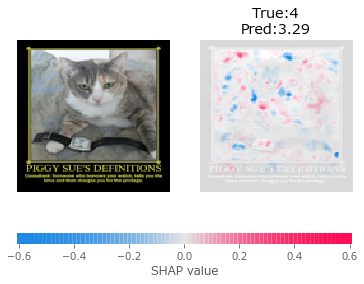

<Figure size 1440x1440 with 0 Axes>

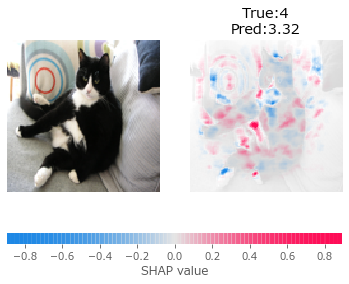

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_127 (Conv2D)          (None, 118, 118, 16)      448       
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 116, 116, 16)      2320      
_________________________________________________________________
batch_normalization_85 (Batc (None, 116, 116, 16)      64        
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 56, 56, 32)        4640      
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 54, 54, 32)        9248      
_________________________________________________________________
batch_normalization_86 (Batc (None, 54, 54, 32)        128       
__________

<Figure size 1440x1440 with 0 Axes>

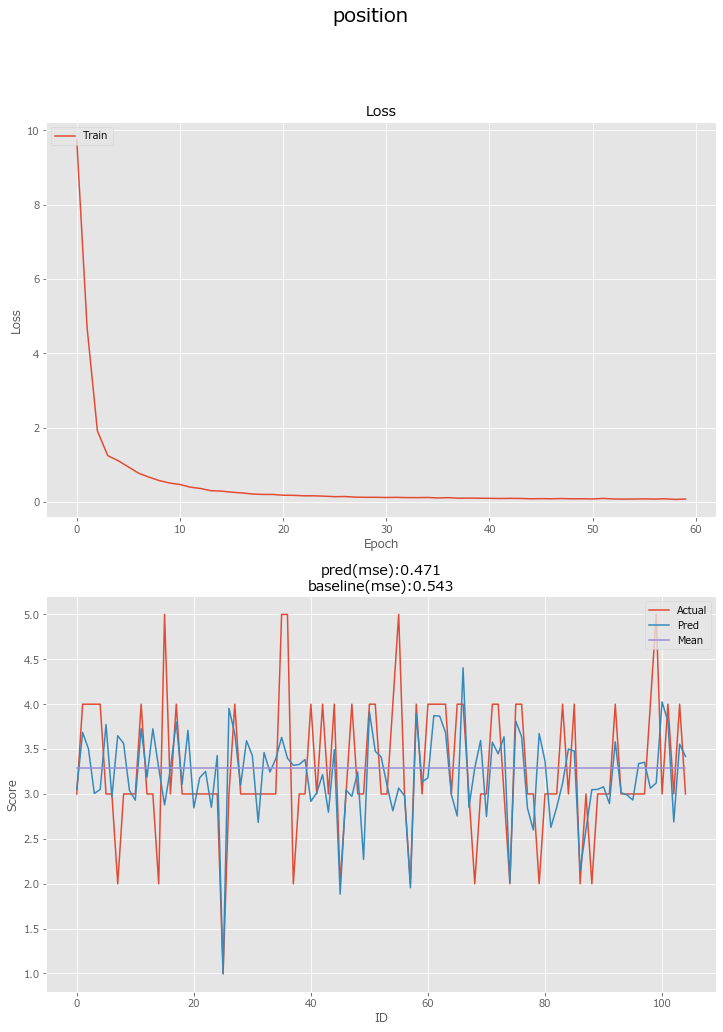

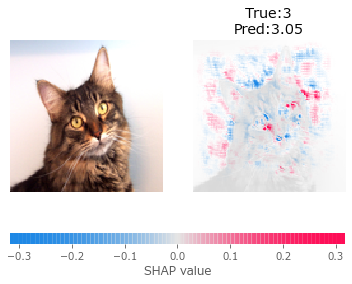

<Figure size 1440x1440 with 0 Axes>

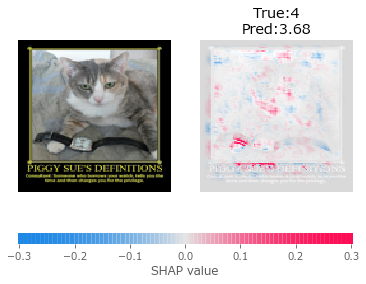

<Figure size 1440x1440 with 0 Axes>

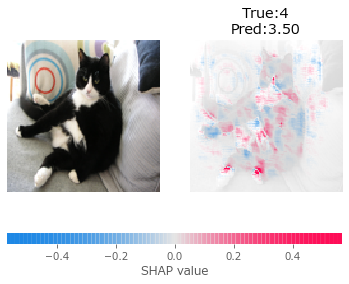

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_133 (Conv2D)          (None, 118, 118, 16)      448       
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 116, 116, 16)      2320      
_________________________________________________________________
batch_normalization_89 (Batc (None, 116, 116, 16)      64        
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 56, 56, 32)        4640      
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 54, 54, 32)        9248      
_________________________________________________________________
batch_normalization_90 (Batc (None, 54, 54, 32)        128       
__________

<Figure size 1440x1440 with 0 Axes>

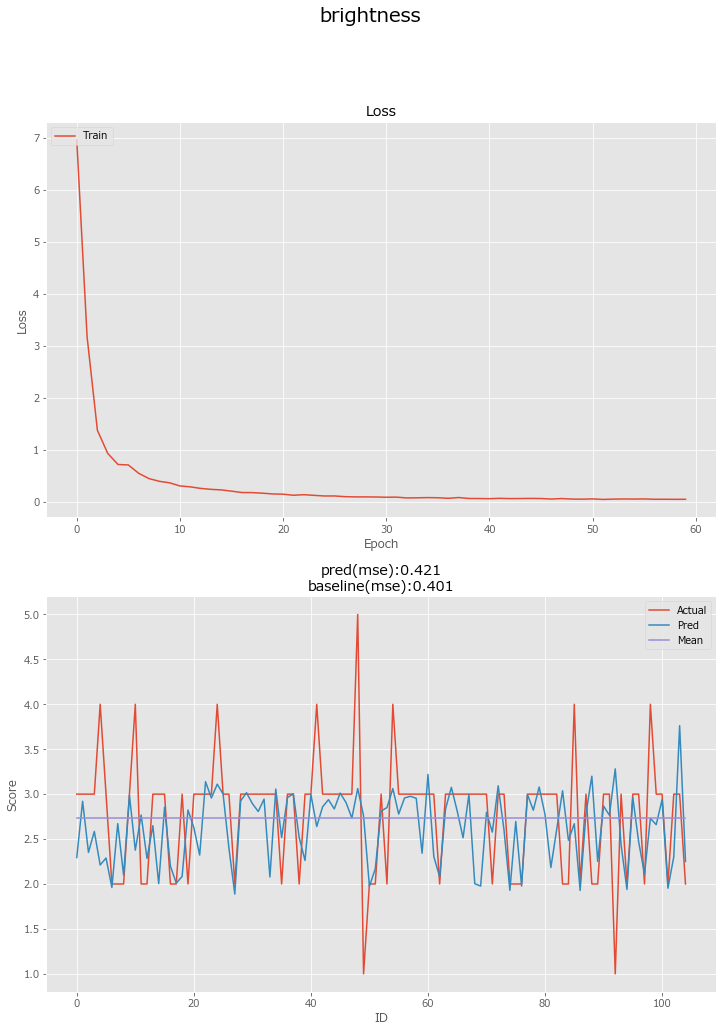

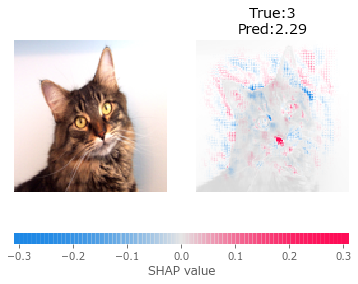

<Figure size 1440x1440 with 0 Axes>

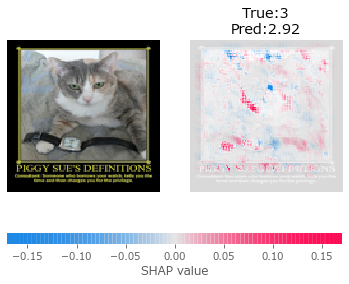

<Figure size 1440x1440 with 0 Axes>

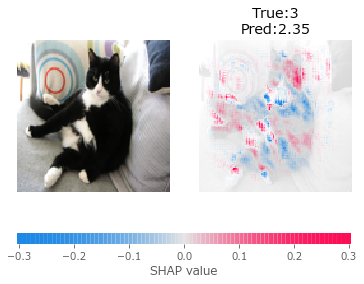

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 118, 118, 16)      448       
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 116, 116, 16)      2320      
_________________________________________________________________
batch_normalization_93 (Batc (None, 116, 116, 16)      64        
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 56, 56, 32)        4640      
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 54, 54, 32)        9248      
_________________________________________________________________
batch_normalization_94 (Batc (None, 54, 54, 32)        128       
__________

<Figure size 1440x1440 with 0 Axes>

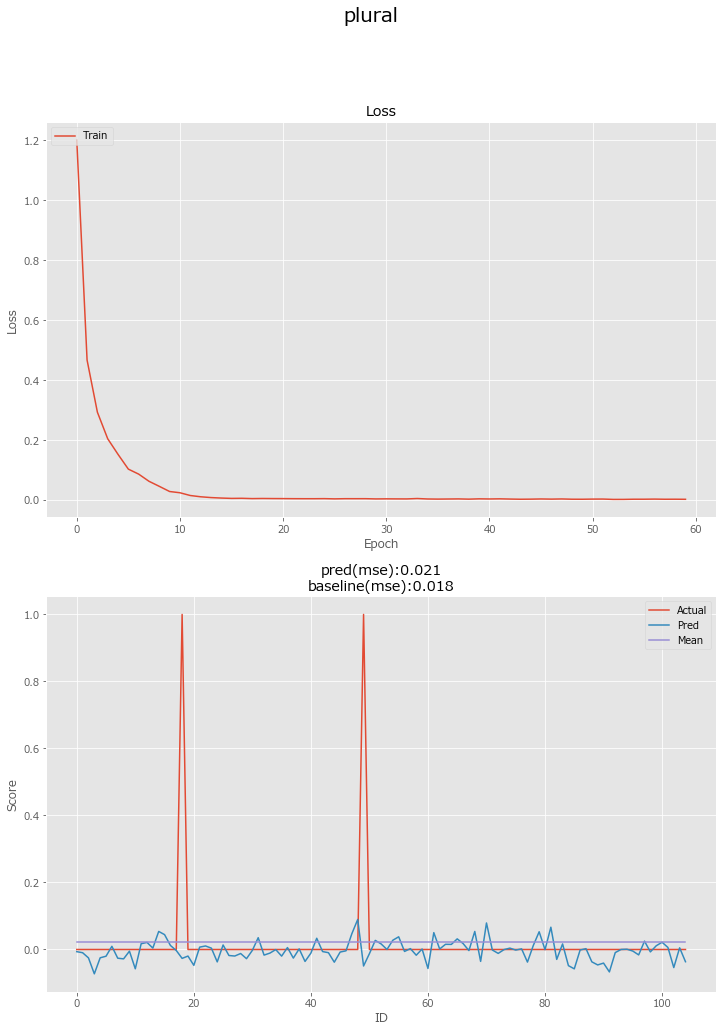

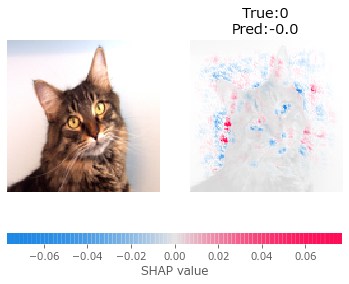

<Figure size 1440x1440 with 0 Axes>

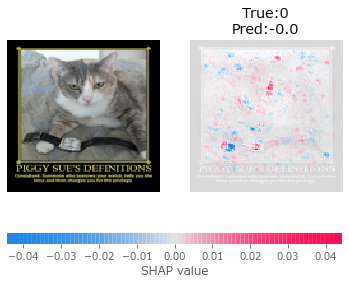

<Figure size 1440x1440 with 0 Axes>

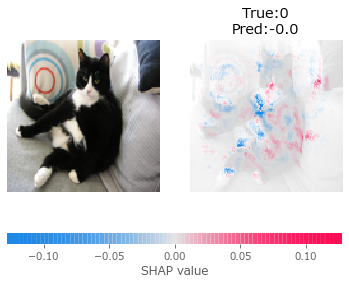

<Figure size 1440x1440 with 0 Axes>

In [96]:
#predict_df = pd.DataFrame(index=["MSE_pred","MSE_mean"])
pred_list = []
for i,column in enumerate(["front","close","background","focus","cute","position","brightness","plural"]):
    print("============================================================")
    pred_list.append(column_predict(X_train,X_valid,y_train.T[i],y_valid.T[i],column))

## 4, 大モデル作成

In [97]:
X2 = df[["front","close","background","focus","cute","position","brightness","plural"]]
Y2 = df["care"].values

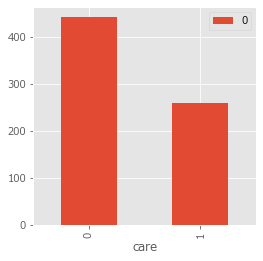

In [98]:
#偏りはsample_weightで調整する予定
pd.DataFrame(df.groupby("care").size()).plot(kind = "bar", figsize = (4, 4))
plt.show()

In [99]:
#最適化される関数
def objective(x,y,trial):
    params={
        "num_leaves":trial.suggest_int("num_leaves",30,400),
        "learning_rate":trial.suggest_uniform("learning_rate",0.1,3.0),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.1,1.0),
        "max_depth":trial.suggest_int("max_depth",3,12),
        "objective":trial.suggest_categorical("objective",["binary"]),
        "random_state":trial.suggest_int("random_state",0,0)
    }
    
    score = 0
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
    for train_index,test_index in kf.split(x,y):
        X_train = x.iloc[train_index]
        X_test = x.iloc[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        score += accuracy_score(y_test,pred)
    return score    

In [100]:
def last_predict(X,Y,image):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = 0,test_size = 0.15)

    evals_result = {}
    study = optuna.create_study(direction="maximize",sampler=optuna.samplers.RandomSampler(seed=0))
    study.optimize(partial(objective,X_train,y_train),n_trials=100)
    model = lgb.LGBMClassifier(**study.best_params)
    model.fit(X_train, y_train,callbacks=[lgb.record_evaluation(evals_result)])
    pickle.dump(model,open("model/model_lgb.sav","wb"))
    
    #lgbのlossをグラフに出す予定
    #train_metric = evals_result['validation_0']['loss']
    #plt.plot(train_metric, label='train loss')
    #plt.grid()
    #plt.legend()
    #plt.xlabel('rounds')
    #plt.ylabel('logloss')
    #plt.show()
    
    pred = model.predict(X_test)
    acc = accuracy_score(pred, y_test)
    print("acc:" + str(acc)[:4])
    print()
    print("confusion_matrix:")
    cm = ConfusionMatrix(pred, y_test)
    cm.print_matrix()
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_test, label="Actual")
    plt.plot(pred, c="b", label="pred", alpha=0.6)
    plt.legend(loc="upper right")
    plt.show()
    
    Xcolumns = X.columns
    features = Xcolumns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    #importance
    plt.figure(figsize=(8,4))
    plt.title("importance")
    plt.barh(range(len(indices)),importances[indices],align="center")
    plt.yticks(range(len(indices)),features[indices])
    plt.show()
    
    #shap
    explainer = shap.TreeExplainer(model,X)    
    for i in range(3):
        print(str(i))
        plt.imshow(image[i])
        plt.show()
        
        shap_values = explainer.shap_values(X.loc[[i]])
        shap.force_plot(explainer.expected_value, 
                    shap_values, 
                    X.loc[[i]], 
                    matplotlib=True,
                    )

In [101]:
def last_predict_dt(X,Y,image):
    from IPython.display import Image
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = 0,test_size = 0.15)

    evals_result = {}
    model = DecisionTreeClassifier(max_depth=4)
    model.fit(X_train, y_train)
    pickle.dump(model,open("model/model_dt.sav","wb"))
    
    #lgbのlossをグラフに出す予定
    #train_metric = evals_result['validation_0']['loss']
    #plt.plot(train_metric, label='train loss')
    #plt.grid()
    #plt.legend()
    #plt.xlabel('rounds')
    #plt.ylabel('logloss')
    #plt.show()
    
    pred = model.predict(X_test)
    acc = accuracy_score(pred, y_test)
    print("acc:" + str(acc)[:4])
    print()
    print("confusion_matrix:")
    cm = ConfusionMatrix(pred, y_test)
    cm.print_matrix()
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_test, label="Actual")
    plt.plot(pred, c="b", label="pred", alpha=0.6)
    plt.legend(loc="upper right")
    plt.show()
    
    Xcolumns = X.columns
    features = Xcolumns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    #importance
    plt.figure(figsize=(8,4))
    plt.title("importance")
    plt.barh(range(len(indices)),importances[indices],align="center")
    plt.yticks(range(len(indices)),features[indices])
    plt.show()
    
    #shap
    explainer = shap.TreeExplainer(model)    
    for i in range(3):
        print(str(i))
        plt.imshow(image[i])
        plt.show()
        
        shap_values = explainer.shap_values(X.loc[[i]])
        shap.force_plot(explainer.expected_value[0], 
                    shap_values[0], 
                    X.loc[[i]], 
                    matplotlib=True,
                    )
    
    dot_data = StringIO()
    tree.export_graphviz(model, 
                        class_names=["not_care","care"],
                        feature_names=["front","close","background","focus","cute","position","brightness","plural"],
                        filled=True,
                        rounded=True,
                        out_file=dot_data
                    )
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_pdf("graph1.pdf")
    Image(graph.create_png())
    graph

acc:0.74

confusion_matrix:
Predict  0        1        
Actual
0        56       13       

1        14       22       




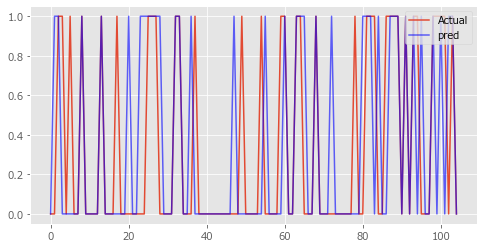

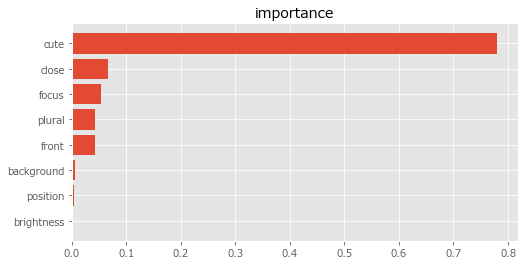

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


0


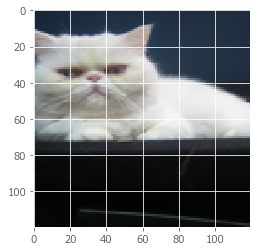

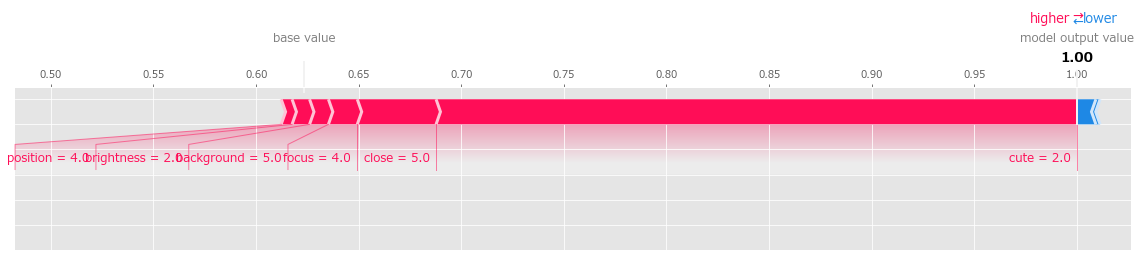

1


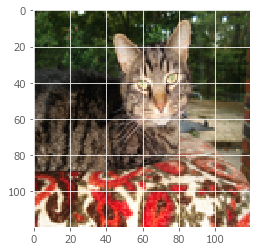

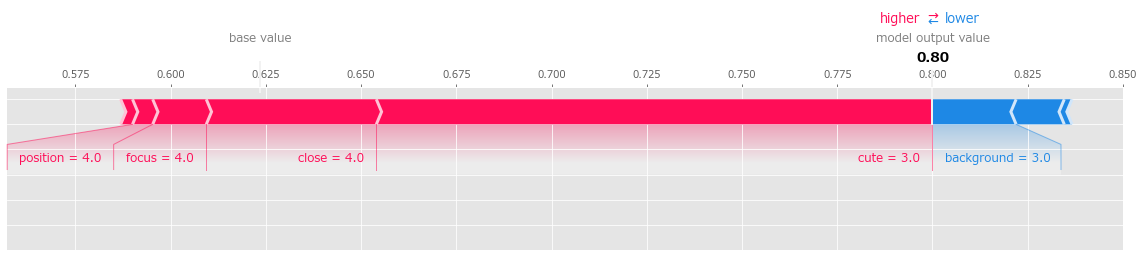

2


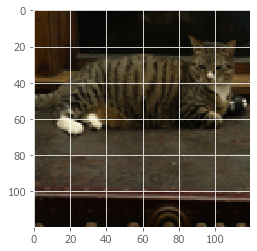

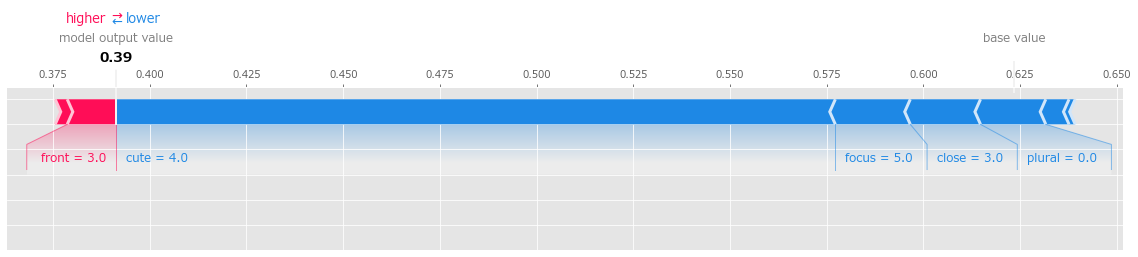

In [102]:
last_predict_dt(X2,Y2,X)

## 5, 保護有無の予想

In [103]:
#小モデルの予想結果を大モデルに投入して保護有無を予想する
model = pickle.load(open("model/model_lgb.sav","rb"))
X_pred = np.squeeze(np.array(pred_list).T)
pred = model.predict(X_pred)
#shap値を出す予定
#レーダーチャートを出す予定
print("base_acc:" + str(accuracy_score(np.zeros(len(pred)),np.squeeze(care_valid)))[:4])
print("acc:" + str(accuracy_score(pred,np.squeeze(care_valid)))[:4])
print()
print("confusion_matrix:")
cm = ConfusionMatrix(pred,np.squeeze(care_valid))
cm.print_matrix()

base_acc:0.57
acc:0.58

confusion_matrix:
Predict  0        1        
Actual
0        45       29       

1        15       16       




care_true:1
care_pred:0


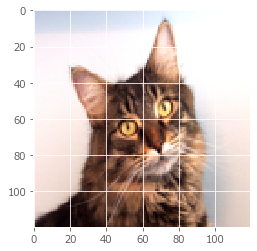

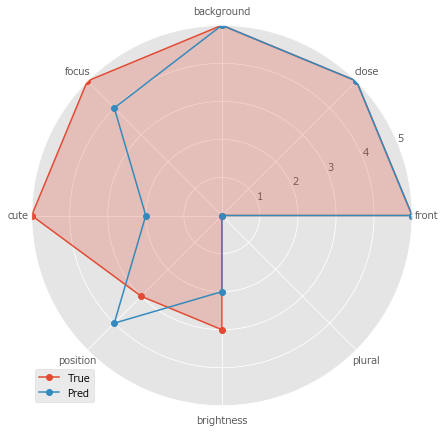

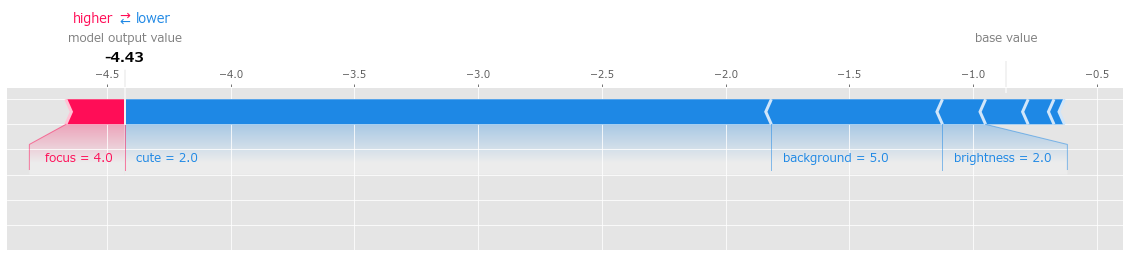

care_true:1
care_pred:0


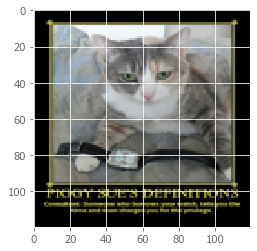

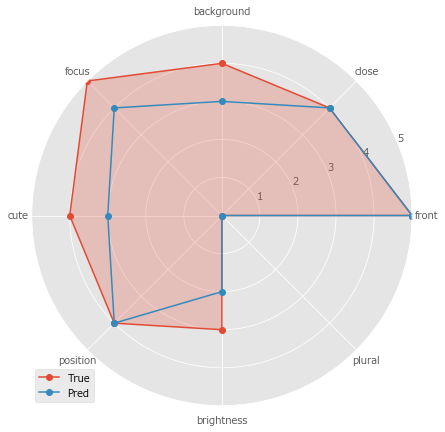

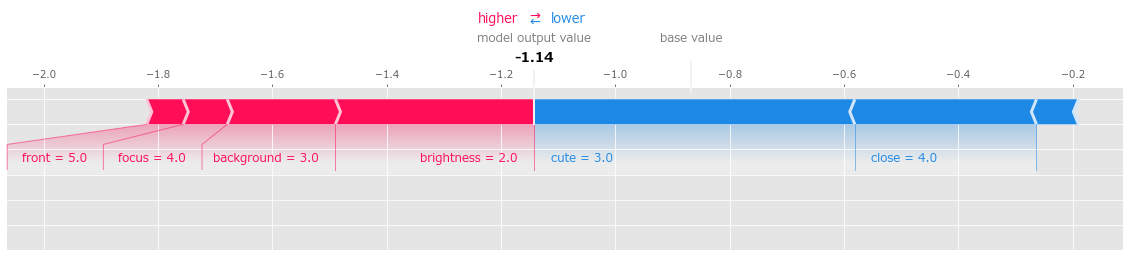

care_true:1
care_pred:0


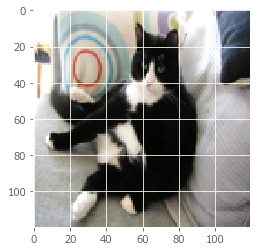

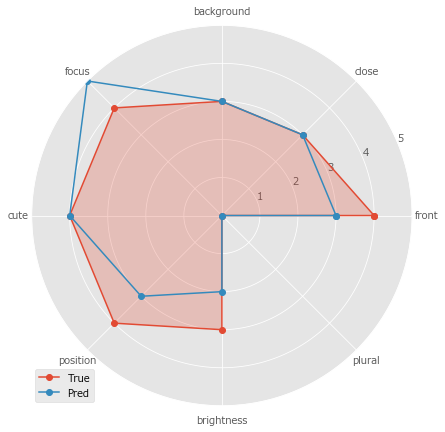

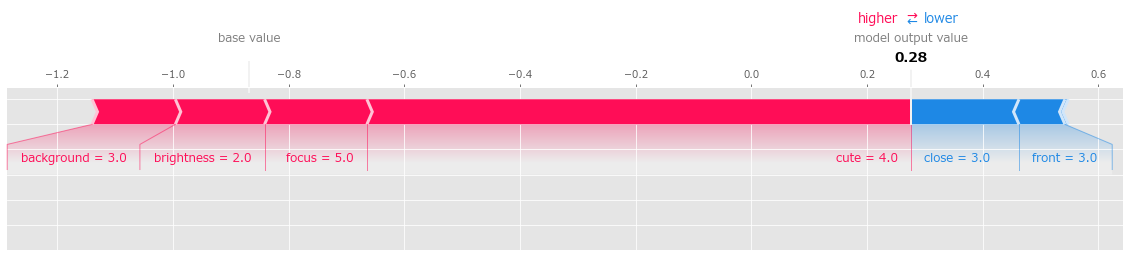

care_true:0
care_pred:0


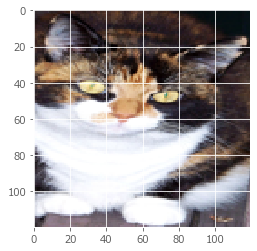

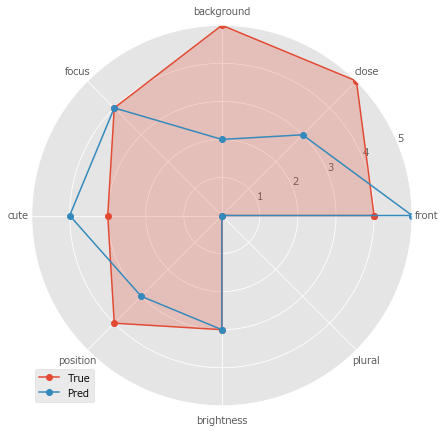

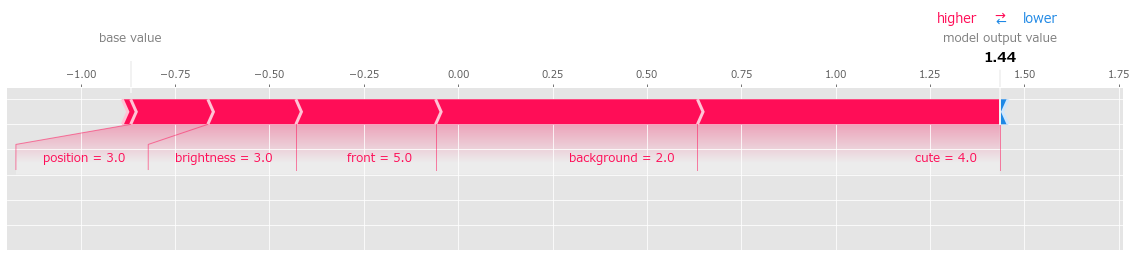

care_true:1
care_pred:0


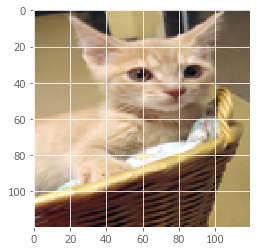

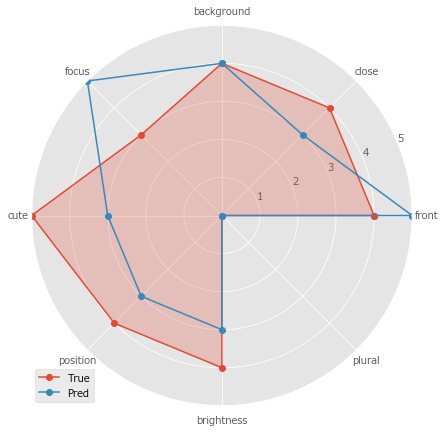

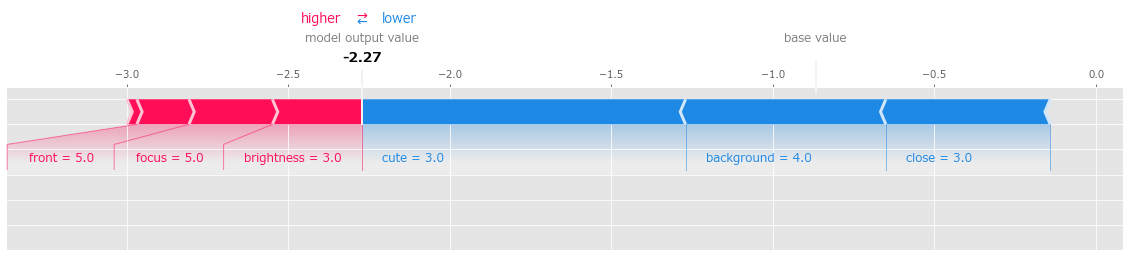

In [104]:
explainer = shap.TreeExplainer(model,X2)
sample_num = 5
for i in range(sample_num):
    print("care_true:" + str(care_valid[i][0]))
    print("care_pred:" + str(pred[i]))
    
    plt.imshow(X_valid[i])
    plt.show()
    
    plot_polar(["front","close","background","focus","cute","position","brightness","plural"], y_valid[i], np.squeeze(X2.loc[[i]].values))

    shap_values = explainer.shap_values(X2.loc[[i]])
    shap.force_plot(explainer.expected_value, 
                shap_values, 
                X2.loc[[i]], 
                matplotlib=True,
                )
    print("=======================================")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


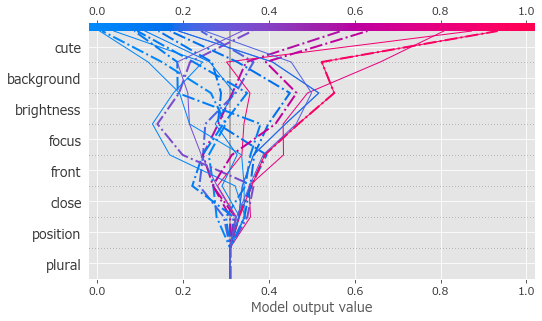

In [105]:
sample_num = 20
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X2)
#予想が外れたら点線で表示
misclassified = (pred[0:sample_num] != np.squeeze(care_valid)[0:sample_num])
shap.decision_plot(explainer.expected_value[1], shap_values[1][0:sample_num], X2[0:sample_num],link="logit",highlight=misclassified)

## 以下考察中

In [121]:
#高速版(未完成)
layer = 8

feed_dict = dict(zip([model.layers[0].input], [X.copy() * 255]))

In [122]:
feed_dict

{<tf.Tensor 'conv2d_38_input:0' shape=(?, 60, 60, 3) dtype=float32>: array([[[[0.09019608, 0.14117648, 0.20392157],
          [0.09411765, 0.14509805, 0.20392157],
          [0.09411765, 0.14901961, 0.20784314],
          ...,
          [0.10980392, 0.17254902, 0.23529412],
          [0.10980392, 0.17254902, 0.23137255],
          [0.10588235, 0.16862746, 0.22745098]],
 
         [[0.09411765, 0.14509805, 0.20392157],
          [0.09411765, 0.14509805, 0.20784314],
          [0.09411765, 0.14901961, 0.20784314],
          ...,
          [0.11372549, 0.1764706 , 0.23529412],
          [0.10980392, 0.17254902, 0.23529412],
          [0.10980392, 0.16862746, 0.23137255]],
 
         [[0.09803922, 0.15294118, 0.21176471],
          [0.09803922, 0.14901961, 0.21176471],
          [0.09411765, 0.14901961, 0.21176471],
          ...,
          [0.11372549, 0.1764706 , 0.23529412],
          [0.11372549, 0.17254902, 0.23529412],
          [0.10980392, 0.16862746, 0.23137255]],
 
         ...,


In [123]:
temp = K.get_session().run(model.layers[layer].input, feed_dict)

In [124]:
e = shap.DeepExplainer(
    (model.layers[layer].input, model.layers[-1].output),
    temp,
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


keras is no longer supported, please use tf.keras instead.


AttributeError: 'list' object has no attribute 'shape'

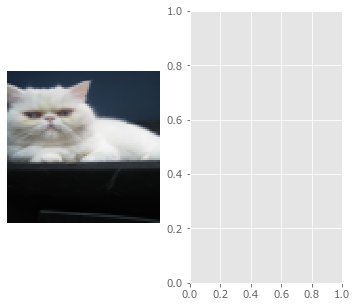

In [12]:
shap_values = e.shap_values(map2layer(X[[0]], 8), ranked_outputs=1)

shap.image_plot(shap_values, X[[0]] * 255, show=False)
plt.gcf().set_size_inches(20, 20)